In [1]:
# default_exp made

In [2]:
#hide
%load_ext autoreload
%autoreload 2

# MADE model

> Masked Autoencoder for Distribution Estimation https://arxiv.org/abs/1502.03509.

In [3]:
# export
import torch
from torch import nn
import torch.nn.functional as F

from typing import Sequence

In [4]:
# hide
import matplotlib.pyplot as plt


In [5]:
d, k = 2,4
m = torch.randint(0, d-1, (k,))
i = torch.arange(d)
j = torch.arange(k)
input_mask = torch.where(m[j][..., None] >= i[None], 1., 0.)
input_mask
output_mask = torch.where(i[..., None] > m[j][None], 1., 0.)
output_mask
output_mask @ input_mask


tensor([[0., 0.],
        [4., 0.]])

In [6]:
# export
def make_masks(d:int, ks:Sequence):
    L = len(ks)
    ms = [torch.arange(d)]
    masks = []
    for l, k in enumerate(ks):
        m = torch.randint(min(ms[l]), d-1, (k,))
        ms.append(m)
        mask = torch.where(ms[l+1][..., None] >= ms[l][None], 1., 0.)
        masks.append(mask)
    mask = torch.where(ms[0][..., None] > ms[-1][None], 1., 0.)
    masks.append(mask)
    return masks


torch.Size([4, 2])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([2, 4])


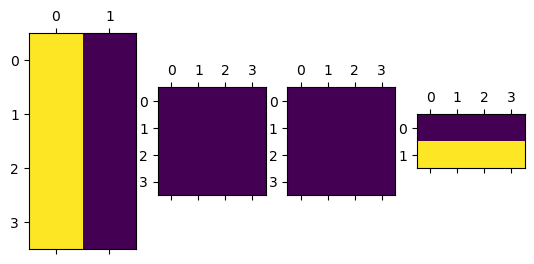

In [7]:
masks = make_masks(2, [4]*3)
torch.linalg.multi_dot(masks[::-1]).bool().float()
for mask in masks:
    print(mask.shape)
fig, axs = plt.subplots(1, len(masks))
for ax, mask in zip(axs, masks):
    ax.matshow(mask)
plt.show()


In [8]:
# export
class MaskedLinear(nn.Module):
    "Masked linear layer"
    def __init__(self, d_in:int, d_out:int, mask=None):
        super().__init__()
        self.w = nn.Parameter(torch.randn(d_out, d_in))
        self.b = nn.Parameter(torch.zeros(d_out))
        if mask is None:
            mask = torch.ones(d_out, d_in)
        else:
            assert mask.size() == self.w.size()
        self.register_buffer("mask", mask)
        torch.nn.init.kaiming_normal_(self.w)

    def forward(self, x, mask=None):
        if mask is not None:
            return F.linear(x, self.w*mask, self.b)
        elif self.mask is not None:
            return F.linear(x, self.w*self.mask, self.b)
        else:
            print("Using `MaskedLinear` but no mask is provided. Layer acts like nn.Linear")
            return F.linear(x, self.w, self.b)

    def set_mask(self, mask:torch.Tensor):
        assert mask.size() == self.w.size()
        self.mask = mask


In [9]:
m = MaskedLinear(d,k)
m.set_mask(masks[0])
m.mask
x = torch.rand(5, d)
out1 = m(x)

x[:, 1] = torch.rand(5)
out2 = m(x)
assert torch.all(out1 == out2)
out2


tensor([[-0.8757, -0.0918,  0.1242,  0.4327],
        [-0.8374, -0.0877,  0.1188,  0.4137],
        [-0.2710, -0.0284,  0.0385,  0.1339],
        [-0.0614, -0.0064,  0.0087,  0.0303],
        [-0.5964, -0.0625,  0.0846,  0.2947]], grad_fn=<AddmmBackward>)

In [10]:
# export
class SimpleMADE(nn.Module):

    def __init__(self, d_in:int, d_h:int, n_layers:int, add_direct=True):
        super().__init__()
        dims = [d_in] + [d_h]*n_layers + [d_in]
        masks = make_masks(d_in, dims[1:-1])
        layers = [MaskedLinear(dims[i], dims[i+1], masks[i]) for i in range(len(masks))]
        self.net = nn.Sequential(*layers)
        if add_direct:
            self.direct = MaskedLinear(d_in, d_in, torch.tril(torch.ones(d_in, d_in), diagonal=-1))
        else:
            self.direct = None
    
    def forward(self, x):
        out = self.net(x)
        if self.direct is not None:
            out += self.direct(x)
        return out
        


In [11]:
model = SimpleMADE(2, 4, 2, True)
model
x = torch.rand(5, 2)
model(x)

tensor([[ 0.0000, -0.0571],
        [ 0.0000, -0.0635],
        [ 0.0000, -0.4485],
        [ 0.0000, -0.1129],
        [ 0.0000, -0.0245]], grad_fn=<AddBackward0>)

In [12]:
# hide
class MADE(nn.Module):

    def __init__(self, d_in:int, d_h:int, n_layers:int, add_direct=True, outs_per_input=1):
        super().__init__()
        self.outs_per_input = outs_per_input
        dims = [d_in] + [d_h]*n_layers + [d_in*outs_per_input]
        self.masks = make_masks(d_in, dims[1:-1])
        layers = [MaskedLinear(dims[i], dims[i+1], self.masks[i]) for i in range(len(self.masks)-1)]
        layers += [MaskedLinear(dims[-2], dims[-1])]
        self.layers = nn.ModuleList(layers)
        if add_direct:
            direct_mask = torch.repeat_interleave(
                torch.tril(torch.ones(d_in, d_in), diagonal=-1), outs_per_input, 0
            )
            self.direct = MaskedLinear(d_in, d_in*outs_per_input, direct_mask)
        else:
            self.direct = None
    
    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = layer(out)
        out = self.layers[-1](out, mask=torch.repeat_interleave(self.masks[-1], self.outs_per_input, 0))

        if self.direct is not None:
            out += self.direct(x)
        return out


In [13]:
# export
class MADE(nn.Module):

    def __init__(self, d_in:int, d_h:int, n_layers:int, add_direct=True, outs_per_input=1):
        super().__init__()
        self.outs_per_input = outs_per_input
        dims = [d_in] + [d_h]*n_layers + [d_in*outs_per_input]
        self.masks = make_masks(d_in, dims[1:-1])
        layers = [MaskedLinear(dims[i], dims[i+1], self.masks[i]) for i in range(len(self.masks)-1)]
        layers += [MaskedLinear(dims[-2], dims[-1])]
        self.layers = nn.ModuleList(layers)
        if add_direct:
            direct_mask = torch.tril(torch.ones(d_in, d_in), diagonal=-1).repeat(outs_per_input,1)
            self.direct = MaskedLinear(d_in, d_in*outs_per_input, direct_mask)
        else:
            self.direct = None
    
    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = layer(out)
        out = self.layers[-1](out, mask=self.masks[-1].repeat(self.outs_per_input,1))

        if self.direct is not None:
            out += self.direct(x)
        return out


In [14]:
x=torch.arange(10).reshape(2,5)
x.repeat(1,2)
x = torch.rand(5, 2)
model = MADE(2, 4, 3, outs_per_input=2)
model(x)
d_in = 4
outs_per_input = 2
direct_mask = torch.repeat_interleave(
    torch.tril(torch.ones(d_in, d_in), diagonal=-1), outs_per_input, 0
)
direct = MaskedLinear(d_in, d_in*outs_per_input, direct_mask)
direct_mask


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]])

In [15]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_layers.ipynb.
Converted 01_training.ipynb.
Converted 02_made.ipynb.
Converted index.ipynb.
